In [3]:
# Step 1: imports
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import convolve, gaussian_filter, median_filter
from numpy.fft import fft2, fftshift, ifft2, ifftshift


In [5]:
# Step 2: set filename (replace if needed) and load as 8-bit grayscale
filename = "lena.png"  

if not os.path.exists(filename):
    raise FileNotFoundError(f"File not found: {filename} (put the image in the notebook folder)")

img_pil = Image.open(filename).convert("L")
img = np.array(img_pil)        

print("Using image:", filename)
print("Shape:", img.shape, "dtype:", img.dtype)


Using image: lena.png
Shape: (512, 512) dtype: uint8


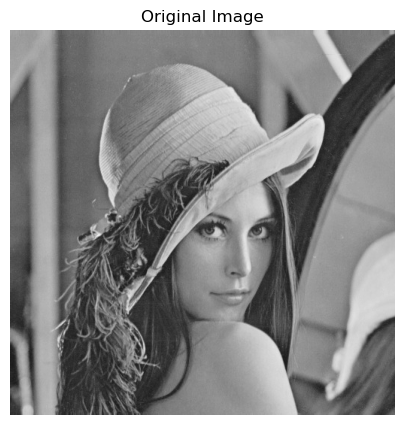

In [7]:
# Step 3: display original
plt.figure(figsize=(5,5))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title("Original Image")
plt.axis('off')
plt.show()


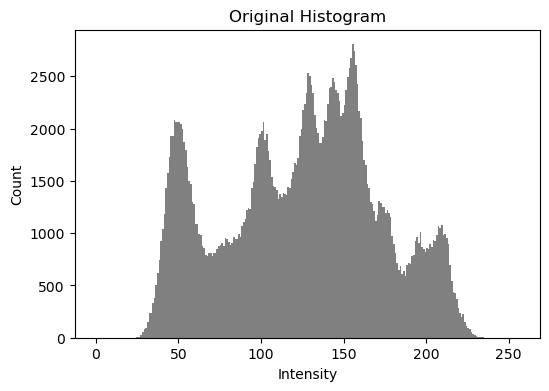

In [9]:
# Step 4: original histogram
plt.figure(figsize=(6,4))
plt.hist(img.ravel(), bins=256, range=[0,256], color='gray')
plt.title("Original Histogram")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.show()


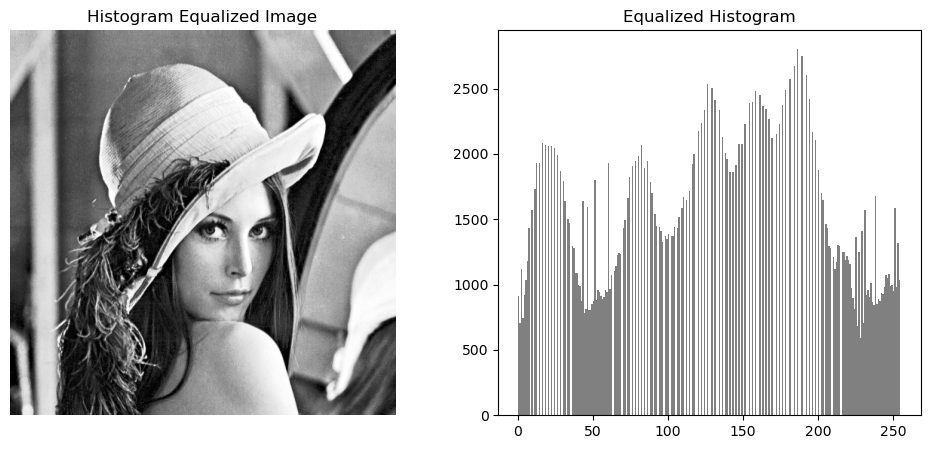

In [11]:
# Step 5: histogram equalization
hist, bins = np.histogram(img.flatten(), 256, [0,256])
cdf = hist.cumsum()

# Mask zeros and normalize CDF to [0,255]
cdf_masked = np.ma.masked_equal(cdf, 0)
cdf_masked = (cdf_masked - cdf_masked.min()) * 255 / (cdf_masked.max() - cdf_masked.min())
cdf_final = np.ma.filled(cdf_masked, 0).astype('uint8')

# Map pixels
img_eq = cdf_final[img]

# Display equalized image + histogram
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img_eq, cmap='gray', vmin=0, vmax=255); plt.title("Histogram Equalized Image"); plt.axis('off')

plt.subplot(1,2,2)
plt.hist(img_eq.ravel(), bins=256, range=[0,256], color='gray'); plt.title("Equalized Histogram")
plt.show()


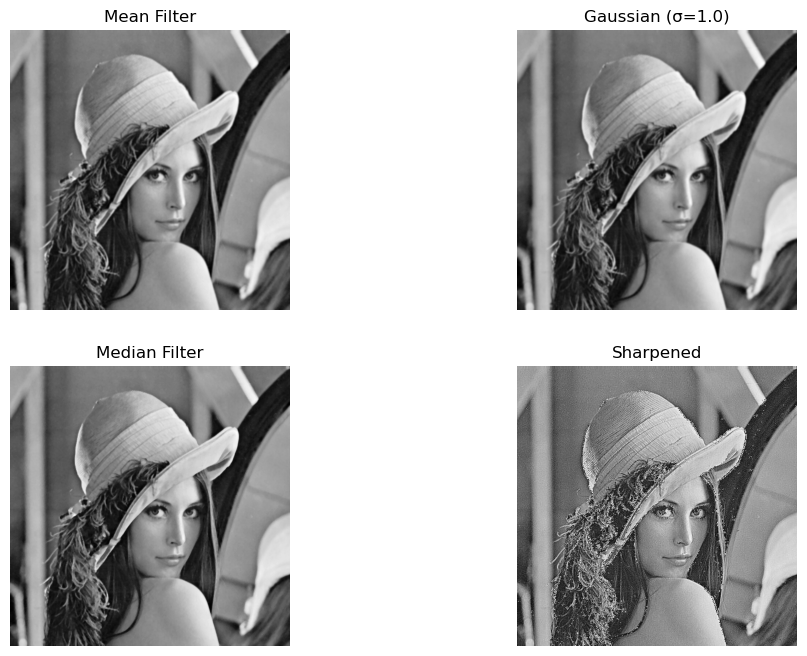

In [13]:
# Step 6: spatial filters (tweak params below)
mean_kernel = np.ones((3,3)) / 9.0     # 3x3 average
gaussian_sigma = 1.0                   # gaussian sigma
median_size = 3                        # median window
sharpen_kernel = np.array([[0,-1,0],   # simple sharpen
                           [-1,5,-1],
                           [0,-1,0]])

# Apply filters (use reflect to reduce border artifacts)
img_mean = convolve(img, mean_kernel, mode='reflect')
img_gaussian = gaussian_filter(img, sigma=gaussian_sigma)
img_median = median_filter(img, size=median_size)
img_sharp = convolve(img, sharpen_kernel, mode='reflect')

# Clip & convert to uint8 for display/saving
img_mean = np.clip(img_mean, 0, 255).astype(np.uint8)
img_gaussian = np.clip(img_gaussian, 0, 255).astype(np.uint8)
img_median = np.clip(img_median, 0, 255).astype(np.uint8)
img_sharp = np.clip(img_sharp, 0, 255).astype(np.uint8)

# Show results
plt.figure(figsize=(12,8))
plt.subplot(2,2,1); plt.imshow(img_mean, cmap='gray'); plt.title("Mean Filter"); plt.axis('off')
plt.subplot(2,2,2); plt.imshow(img_gaussian, cmap='gray'); plt.title(f"Gaussian (σ={gaussian_sigma})"); plt.axis('off')
plt.subplot(2,2,3); plt.imshow(img_median, cmap='gray'); plt.title("Median Filter"); plt.axis('off')
plt.subplot(2,2,4); plt.imshow(img_sharp, cmap='gray'); plt.title("Sharpened"); plt.axis('off')
plt.show()


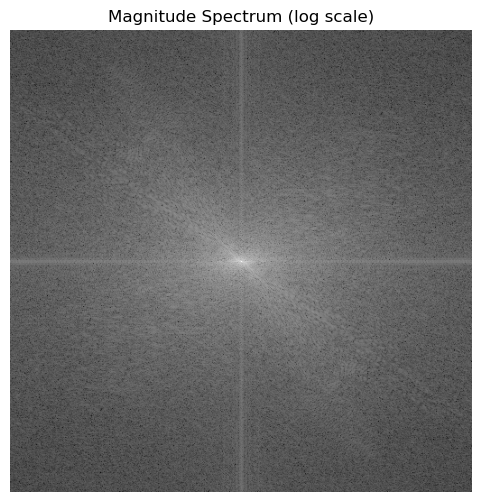

In [15]:
# Step 7: FFT & magnitude spectrum
f = fft2(img)
fshift = fftshift(f)
magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

plt.figure(figsize=(6,6))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title("Magnitude Spectrum (log scale)")
plt.axis('off')
plt.show()


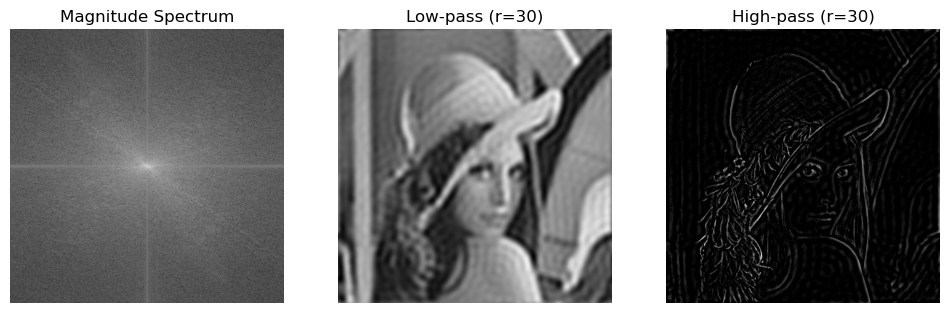

In [17]:
# Step 8: frequency domain filtering (adjust cutoff_radius)
rows, cols = img.shape
crow, ccol = rows//2, cols//2
cutoff_radius = 30   # try 20, 30, 60

Y, X = np.ogrid[:rows, :cols]
dist2 = (X - ccol)**2 + (Y - crow)**2

mask_low = dist2 <= (cutoff_radius**2)   # boolean low-pass mask
mask_high = ~mask_low                    # boolean high-pass mask

# Apply masks in frequency domain
f_low = fshift * mask_low
f_high = fshift * mask_high

# Inverse FFT to spatial domain
img_low = np.real(ifft2(ifftshift(f_low)))
img_high = np.real(ifft2(ifftshift(f_high)))

# Clip & convert to uint8
img_low = np.clip(img_low, 0, 255).astype(np.uint8)
img_high = np.clip(img_high, 0, 255).astype(np.uint8)

# Show results
plt.figure(figsize=(12,6))
plt.subplot(1,3,1); plt.imshow(magnitude_spectrum, cmap='gray'); plt.title("Magnitude Spectrum"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(img_low, cmap='gray'); plt.title(f"Low-pass (r={cutoff_radius})"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(img_high, cmap='gray'); plt.title(f"High-pass (r={cutoff_radius})"); plt.axis('off')
plt.show()
